In [4]:
import numpy
import sys
sys.path.append('./src/')

from circuit_utils import *
from network_utils import *
from learning import *

In [9]:
# Create network from jammed configuration
g = jammed_network(300, seed = 1)

progress: 100%|##########| 1000.00/1000.00 [00:09<00:00]


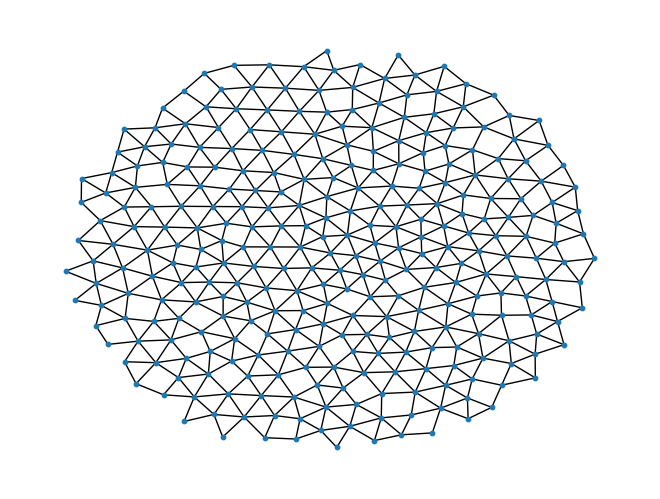

In [10]:
# Visualize network
positions = [g.nodes[i]['pos'] for i in g.nodes]
nx.draw(g, pos=positions, with_labels = False, node_size = 10)

# Train Regression Task

In [11]:
# Define Input and Output of task

# If X_i are the inputs, we want outputs Y_i to follow: Y_1 = 0.1*X_1 + 0.5*X_2, Y_2 = 0.4*X_1 + 0.2*X_2
coefficients = np.array([[0.1, 0.5], [0.4, 0.2]])
TrainDataInput = np.random.rand(100, 2)

# Add zero to each input sample for the ground node
TrainDataOutput = np.dot(coefficients, TrainDataInput.T).T 

inputs_source = np.c_[TrainDataInput, np.zeros((100,1))]
train_data = split_data_into_batches(inputs_source, TrainDataOutput, 1)

In [12]:
# Choose initial conductances for network and initialize CL object
initial_conductances = 1e-6*(1+0.1*np.random.rand(len(list(g.edges))))
# allo = CL(g, initial_conductances, learning_rate=0.01, learning_step = 0, jax=False)
allo = learning(g, initial_conductances, jax=False)

# Choose source and target nodes for regression task
indices_source = np.array([0,50,100])
indices_target = np.array([20,210])

current_bool = np.array([False for i in range(len(indices_source))]) # all the input nodes are voltage nodes

_ = allo.set_inputs(indices_source, current_bool)
_ = allo.set_outputs(indices_target)

In [8]:
# training parameters
eta = .01                   # Coupled Learning nudge amplitude

n_epochs = 50              # number of epochs
n_steps_per_epoch = 10      # number of steps per epoch
batch_size = 30             # batch size   

allo.learning_rate = 1      # learning rate

verbose = False            # print progress
pbar = True                # progress bar
log_spaced = False         # log spaced epochs

_ = allo.train_CL(allo.learning_rate,
                eta,
                train_data,
                n_epochs,
                save_every = 1,
                save_global = True,
                save_state = True, 
                save_path = 'test',
                verbose = True)

Epoch: 17/50 | Loss: 3.31e-24:  36%|███▌      | 18/50 [00:02<00:05,  6.24it/s]

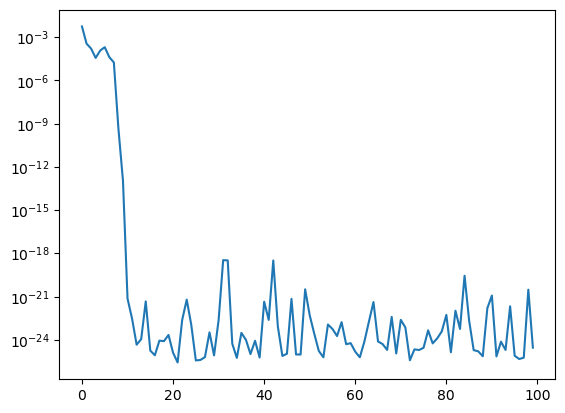

In [10]:
# Plot loss along training
plt.plot(allo.loss_history)
plt.yscale('log')

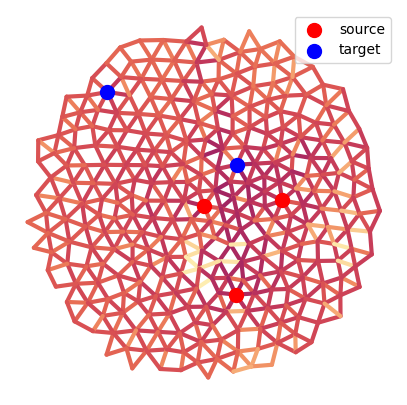

In [11]:
# Visualize trained circuit conductances and source and target nodes

fig, axs = plt.subplots(1,1, figsize=(5,5))

allo.edge_state_to_ax(axs, allo.conductances, vmin=1e-6, vmax=1e2, color_scale='log', lw=3)

axs.scatter(allo.pts[indices_source,0], allo.pts[indices_source,1], s=100, c='r', marker='o', zorder=2, label='source')

axs.scatter(allo.pts[indices_target,0], allo.pts[indices_target,1], s=100, c='b', marker='o', zorder=2, label='target')
axs.legend()

axs.set_axis_off()